# Dynamic QSP reporting with Julia and Jupiter

_This is an example of creation of a dynamic QSP report in Julia and IJulia.jl (Jupiter) build based on HetaSimulator.jl. The content of this file and modeling platform is published in GitHub repository <https://github.com/insysbio/insulin-signaling-t2d>_

## Preamble

The QSP model which is used as an example of QSP model was published in the article:

> Brannmark C, Nyman E, Fagerholm S, Bergenholm L, Ekstrand EM, Cedersund G, Stralfors P. Insulin Signaling in Type 2 Diabetes: Experimental and modeling analyses reveal mechanisms of insulin resistance in human adipocytes. Journal of biological chemistry.. 2013 288(14):9867–9880. DOI: 10.1074/jbc.M112.432062

The SBML code was downloaded from BioModels <https://www.ebi.ac.uk/biomodels/BIOMD0000000448> and used as the part of the [Heta-based](https://hetalang.github.io/#/) modeling platform.

The report includes the steps to reproduce simulations from the original article demonstration facilities of the approach and necessary setups.

All necessary files can also be found in the [repository](https://github.com/insysbio/insulin-signaling-t2d).

## Preparations

For easier creation of the Heta-based platform install [heta compiler](https://hetalang.github.io/#/heta-compiler/?id=installation).

In command line interface run the code below to create heta platform template

```sh
heta init
```
The minimal content will be created.

Download the SBML model [from the database](https://www.ebi.ac.uk/biomodels/BIOMD0000000448) and copy it into `src/BIOMD0000000448.xml`

Update the `src/index.heta` with the following content:

```heta
// load SBML model as a content of the platform
include BIOMD0000000448_url.xml type sbml

// make the records of a model observable
block {output: true} begin
  measuredIRp;
  measuredIRint;
  measuredIRS1p;
  measuredIRS1307;
  measuredPKB308p;
  measuredPKB473p;
  measuredAS160p;
  measuredmTORC1a;
  measuredS6Kp;
  glucoseuptake;
  measuredmTORC2a;
  measuredS6p;
end

// make insulin as an input of the model
insulin @Const = 10; // nM

// make IR (insuline resistance) specific parameters as an input of the model
IR_total @Const = 100;    // reduce to 55%
GLUT4_total @Const = 100; // GLUT4 reduce to 50%
diabetes @Const = 1;      // reduce to 15%

// recalculate initial values for IR and base conditions
IR .= IR_total * 99.87/100; // 99.87
IRp .= 0;
IRins .= 0;
IRip .= IR_total * 0.02/100;      // 0.02
IRi .= IR_total * 0.11/100;       // 0.11
//
GLUT4 .= GLUT4_total * 73.48/100;   // 73.48
GLUT4m .= GLUT4_total * 26.52/100;  // 26.52

// variable parameters
k1a @Const = 0.6331;
k1basal @Const = 0.03683;
k1c @Const = 0.8768;
k1d @Const = 31.01;
```

Install [Julia](https://julialang.org/downloads/) and add all necessary packages in Julia's console:

```julia
] add HetaSimulator StatsPlots IJulia.jl
```

Run Jupiter notebook engine

```julia
using IJulia
notebook(dir=".")
```

## Loading platform

In [1]:
using HetaSimulator, StatsPlots

In [2]:
p = load_platform("..", rm_out = true) # set heta platform location here

Running compilation with declaration file "Y:\PLATFORMS\insulin-signaling-t2d\platform.json"...
[info] Builder initialized in directory "Y:\PLATFORMS\insulin-signaling-t2d".
[info] Platform id: "template"
[info] Compilation of module "src/index.heta" of type "heta"...
[info] Reading module of type "heta" from file "Y:\PLATFORMS\insulin-signaling-t2d\src\index.heta"...
[info] Reading module of type "sbml" from file "Y:\PLATFORMS\insulin-signaling-t2d\src\BIOMD0000000448_url.xml"...
[info] Setting references in elements, total length 170
[info] Checking for circular references in Records.
[warn] Units checking skipped. To turn it on set "unitsCheck: true" in declaration.
[info] Checking unit's terms.
[warn] "Julia only" mode
[info] Exporting to "Y:\PLATFORMS\insulin-signaling-t2d\_julia" of format "Julia"...
Compilation OK!
Loading platform... OK!


Platform with 1 model(s), 0 scenario(s), 0 measurement(s)
   Models: nameless
   Scenarios: 


In [3]:
m = models(p)[:nameless]

Model contains 8 constant(s), 124 record(s), 0 switcher(s).
   Constants: diabetes, k1a, k1basal, k1c, k1d, insulin, IR_total, GLUT4_total
   Records: cellvolume, IR, IRp, IRins, IRip, IRi, IRS1, IRS1p, IRS1p307, IRS1307, ...
   Switchers (events): 


## Default simulation

To simulate the observables only one line of code is required. Here we are using "chain" with `|>` syntax.

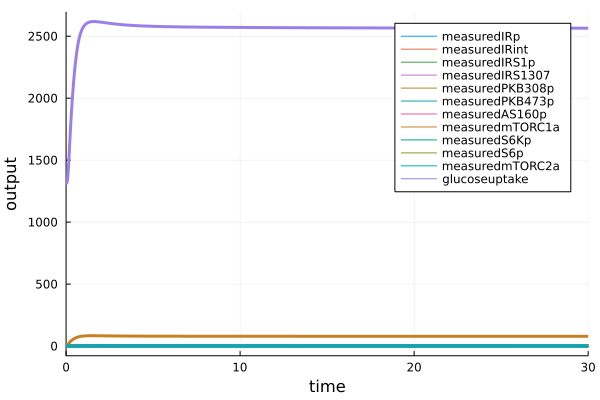

In [4]:
Scenario(m, (0.,30.)) |> sim |> plot

Based on the original publication the insuline resistance (IR) can be set by updating three parameters.

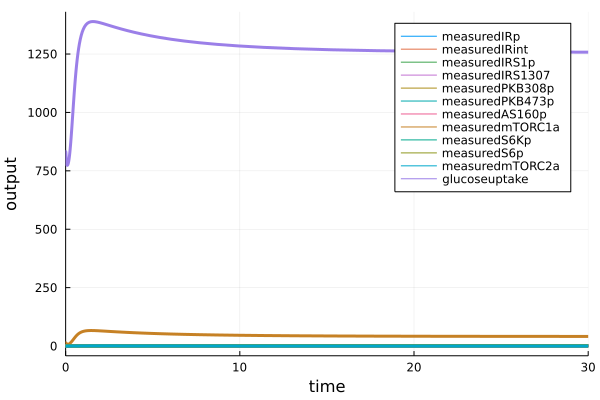

In [5]:
Scenario(m, (0.,30.), parameters = [:IR_total=>55., :GLUT4_total=>50, :diabetes=>0.15]) |> sim |> plot

## Simulation scenarios

Two simulation scenarios above can be created in tabular format and loaded into platform `p`. Create CSV file with the following content:

id | parameters.IR_total | parameters.GLUT4_total | parameters.diabetes | tspan
---|---|---|---|---
base | | | | 30
ir | 55 | 50 | 0.15| 30


In [6]:
scn_csv = read_scenarios("../julia/scenarios.csv") # set csv file location here
add_scenarios!(p, scn_csv)
p

Platform with 1 model(s), 2 scenario(s), 0 measurement(s)
   Models: nameless
   Scenarios: base, ir


## Advanced visualization

If you need to reshape and visualize different simulation results the easier way is to convert simulation results into `DataFrame`.

The following simulations reproduce the figures from the original paper.

In [7]:
results_df = sim(p) |> DataFrame # simulate all scenarios, then convert them
first(results_df, 7)

,t,measuredIRp,measuredIRint,measuredIRS1p,measuredIRS1307,measuredPKB308p
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.104044,0.13,0.123621,0.999125,0.653553
2,7.67533e-6,0.104187,0.13,0.123622,0.999125,0.653554
3,2.29935e-5,0.104468,0.129999,0.123624,0.999125,0.653554
4,4.29785e-5,0.104822,0.129998,0.123626,0.999126,0.653555
5,7.10819e-5,0.105298,0.129996,0.123629,0.999126,0.653557
6,0.000109594,0.105913,0.129994,0.123634,0.999127,0.65356
7,0.000163956,0.106712,0.129992,0.12364,0.999128,0.653564


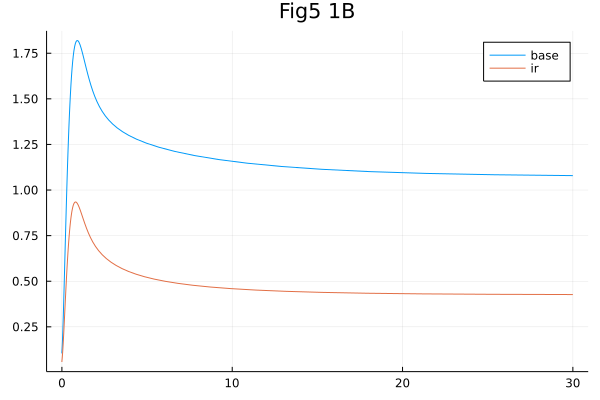

In [8]:
@df results_df plot(:t, :measuredIRp, group = :scenario, title = "Fig5 1B")

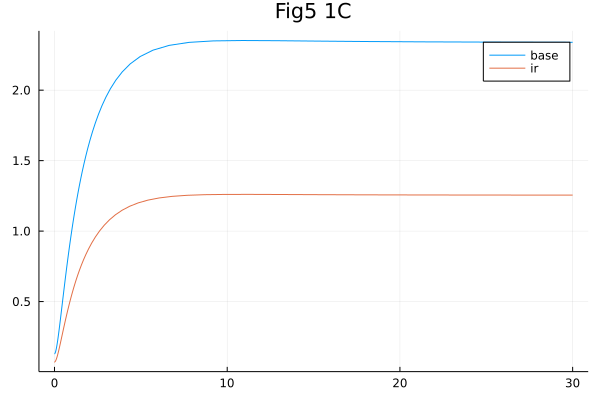

In [9]:
@df results_df plot(:t, :measuredIRint, group = :scenario, title = "Fig5 1C")

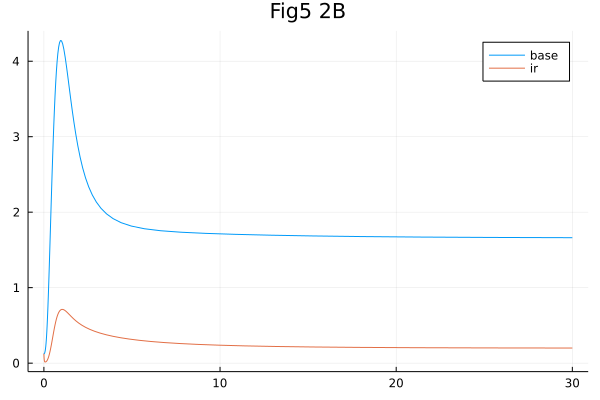

In [10]:
@df results_df plot(:t, :measuredIRS1p, group = :scenario, title = "Fig5 2B")

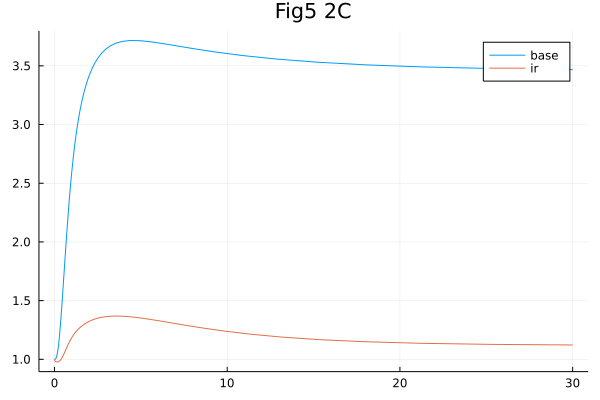

In [11]:
@df results_df plot(:t, :measuredIRS1307, group = :scenario, title = "Fig5 2C")

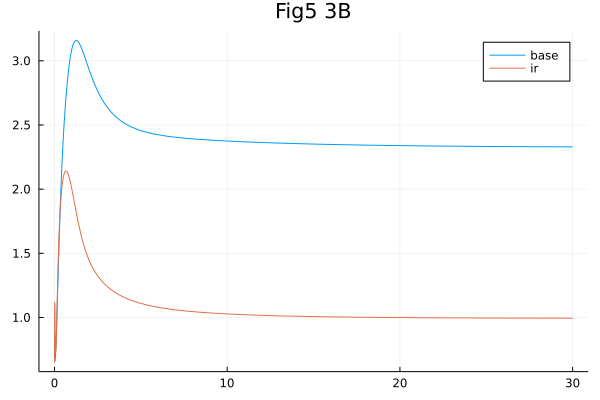

In [12]:
@df results_df plot(:t, :measuredPKB308p, group = :scenario, title = "Fig5 3B")

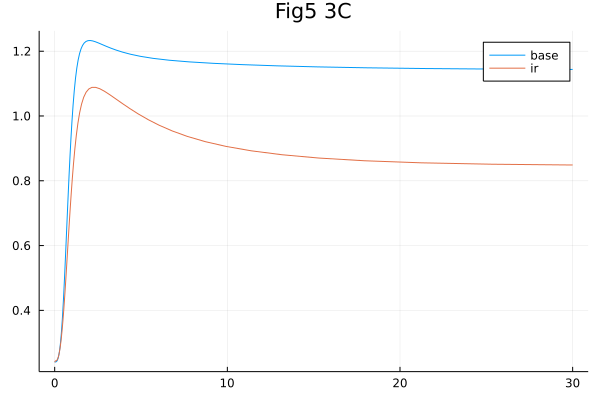

In [13]:
@df results_df plot(:t, :measuredPKB473p, group = :scenario, title = "Fig5 3C")

## Titration-like simulations

The simulations of another type (not time dependence) can be performed and visualized by applying different simulation scenarios. For example in the original article the titration-like experiment is simulated: intake of insulin and measurements of different observables after 10 minutes.

To reproduce them the following set of scenarion should be created:

id | parameters.insulin | parameters.IR_total | parameters.GLUT4_total | parameters.diabetes | tspan | parameters.is_titr
---|---|---|---|---|---|---
base_ins_3 | 1.00E-03 | | | | 10 | 1
base_ins_25 | 3.16E-03 | | | | 10 | 1
base_ins_2 | 1.00E-02 | | | | 10 | 1
base_ins_15 | 3.16E-02 | | | | 10 | 1
base_ins_1 | 1.00E-01 | | | | 10 | 1
base_ins_05 | 3.16E-01 | | | | 10 | 1
base_ins0 | 1.00E+00 | | | | 10 | 1
base_ins05 | 3.16E+00 | | | | 10 | 1
base_ins1 | 1.00E+01 | | | | 10 | 1
base_ins15 | 3.16E+01 | | | | 10 | 1
base_ins2 | 1.00E+02 | | | | 10 | 1
ir_ins_3 | 1.00E-03 | 55 | 50 | 0.15| 10 | 1
ir_ins_25 | 3.16E-03 | 55 | 50 | 0.15| 10 | 1
ir_ins_2 | 1.00E-02 | 55 | 50 | 0.15| 10 | 1
ir_ins_15 | 3.16E-02 | 55 | 50 | 0.15| 10 | 1
ir_ins_1 | 1.00E-01 | 55 | 50 | 0.15| 10 | 1
ir_ins_05 | 3.16E-01 | 55 | 50 | 0.15| 10 | 1
ir_ins0 | 1.00E+00 | 55 | 50 | 0.15| 10 | 1
ir_ins05 | 3.16E+00 | 55 | 50 | 0.15| 10 | 1
ir_ins1 | 1.00E+01 | 55 | 50 | 0.15| 10 | 1
ir_ins15 | 3.16E+01 | 55 | 50 | 0.15| 10 | 1
ir_ins2 | 1.00E+02 | 55 | 50 | 0.15| 10 | 1

In [14]:
scn_titr_csv = read_scenarios("../julia/titration.csv")
add_scenarios!(p, scn_titr_csv)

In [15]:
results_titr = sim(p, saveat=[10.]);
results_titr_df = DataFrame(results_titr, add_parameters=true);
results_titr_subset = subset(results_titr_df, :is_titr=>x->x.===1.);
first(results_titr_subset, 7)

Progress: 100%[==================================================] Time: 0:00:12


,t,measuredIRp,measuredIRint,measuredIRS1p,measuredIRS1307,measuredPKB308p
,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,0.10914,0.126392,0.128691,1.00694,0.657228
2,10.0,0.112292,0.130641,0.140331,1.02449,0.665458
3,10.0,0.122267,0.144005,0.178585,1.08211,0.691793
4,10.0,0.152872,0.185273,0.296577,1.26138,0.779534
5,10.0,0.235619,0.306512,0.562752,1.68342,1.05134
6,10.0,0.41168,0.617149,0.943696,2.32319,1.55237
7,10.0,0.691408,1.21313,1.32394,2.96754,2.01288


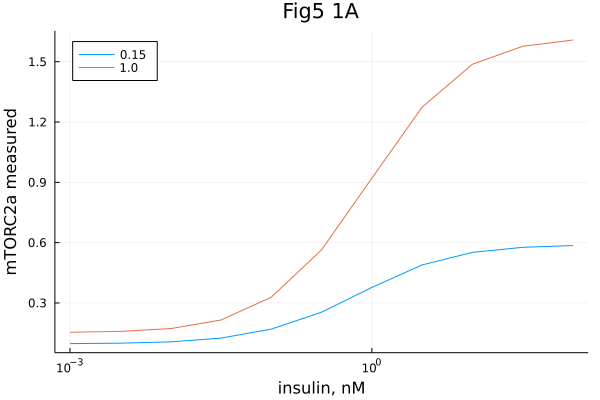

In [16]:
@df results_titr_subset plot(
    :insulin, :measuredmTORC2a,
    title = "Fig5 1A",
    xlabel="insulin, nM", ylabel="mTORC2a measured",
    group=:diabetes,
    xscale = :log10,
    legend = :topleft
)

## Multiple simulations

HetaSimulator includes the mechanism to run Monte-Carlo simulations based on parameter variability. For the demonstration purposes we will generate a random set of parameters: `k1a, k1basal, k1c, k1d`. This simulations mimic the uncertainty in the selected parameters.

In [17]:
results_mc = mc(
    p,
    [
        :k1a => LogNormal(0.6331, 0.5),
        :k1basal => LogNormal(0.03683, 0.5),
        :k1c => LogNormal(0.8768, 0.5),
        :k1d => LogNormal(31.01, 0.5)
    ],
    100,                      # number of 
    scenarios = [:base, :ir], # scenarios names to simulate
    saveat = 0:(0.1):30,      # time points
    abstol = 1e-7
)

2-element Vector{Pair{Symbol, MCResult}}
    :base => 100x301x301 MCResult with status :Success x 100
    :ir => 100x301x301 MCResult with status :Success x 100


In [18]:
plot(results_mc, vars=[:measuredIRp, :measuredIRint])

The generated dataset can be summarized to plot the median and 90% bounds for uncertainty predictions.

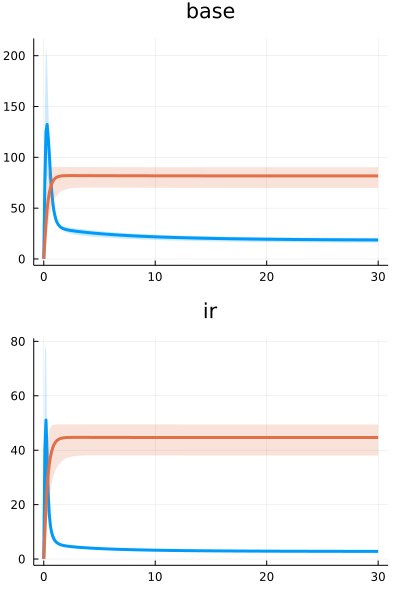

In [19]:
summary_mc = EnsembleSummary(results_mc; quantiles=[0.05,0.95])
plot(summary_mc, idxs=[1,2]) # to plot observables 1 - IRp, 2 - IRint